In [ ]:
!pip install nltk

In [ ]:
import os
import re
import zipfile
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
!python -m nltk.downloader all

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nl

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
os.environ['KAGGLE_USERNAME'] = "ravaradithyarazan"
os.environ['KAGGLE_KEY'] = "6953b3338ffebe88b0b7226e61a1f4f4"

In [ ]:
!kaggle datasets download -f train.txt -d praveengovi/emotions-dataset-for-nlp

  0% 0.00/576k [00:00<?, ?B/s]
100% 576k/576k [00:00<00:00, 135MB/s]


In [ ]:
!kaggle datasets download -f test.txt -d praveengovi/emotions-dataset-for-nlp

100% 202k/202k [00:00<00:00, 1.36MB/s]
100% 202k/202k [00:00<00:00, 1.36MB/s]


In [ ]:
!kaggle datasets download -f glove.6B.200d.txt -d anmolkumar/glove-embeddings

 96% 249M/259M [00:02<00:00, 131MB/s]
100% 259M/259M [00:02<00:00, 114MB/s]


In [ ]:
glove_embedding = '/content/glove.6B.200d.txt.zip'
zip_ref = zipfile.ZipFile(glove_embedding, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
data_zip = '/content/train.txt.zip'
zip_ref = zipfile.ZipFile(data_zip, 'r')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [ ]:
df = pd.read_csv('/content/Data/train.txt', sep=';', names=['Text', 'Emotion'])
df_test = pd.read_csv('/content/test.txt', sep=';', names = ['Text', 'Emotion'])

In [ ]:
df.head(10)

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


In [ ]:
print(df.shape)

(16000, 2)


## Data Cleaning

In [ ]:
df['Emotion'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

<Axes: xlabel='Emotion', ylabel='count'>

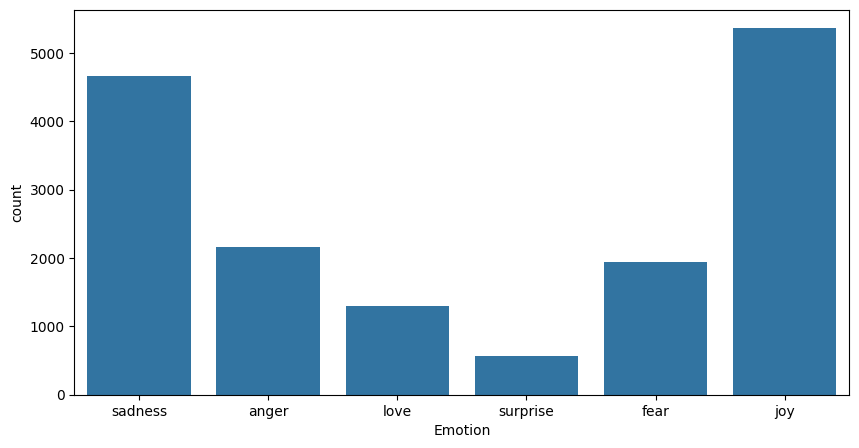

In [ ]:
# Cek persebaran data
plt.figure(figsize=(10, 5))
sns.countplot(x='Emotion', data=df)

In [ ]:
# Cek missing value dan null dalam dataset
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [ ]:
# Cek duplikat
df.duplicated().sum()

1

In [ ]:
# Remove duplikat
index = df[df.duplicated() == True].index
df.drop(index, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
# Cek text duplikat tetapi beda emosi
df[df['Text'].duplicated()==True]

,Text,Emotion
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [ ]:
df[df['Text'] == df.iloc[5067]['Text']]

,Text,Emotion
1501,i feel on the verge of tears from weariness i ...,love
5067,i feel on the verge of tears from weariness i ...,joy


In [ ]:
df[df['Text'] == df.iloc[7333]['Text']]

,Text,Emotion
7333,i feel like i am very passionate about youtube...,joy
13879,i feel like i am very passionate about youtube...,love


In [ ]:
# remove duplikat
index = df[df['Text'].duplicated() == True].index
df.drop(index, axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [ ]:
df[df['Text'].duplicated()==True].sum()

Text       0.0
Emotion    0.0
dtype: float64

In [ ]:
# Menghitung jumlah stopwords
temp = df.copy()
temp['Stopwords'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.Stopwords.value_counts()

5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: Stopwords, dtype: int64

In [ ]:
# stopwords list
stopwords_dict = {}
key = 1

for word in stop_words:
  stopwords_dict[key] = word
  key +=1

print(stopwords_dict)

{1: 'himself', 2: 'do', 3: "couldn't", 4: 're', 5: 'won', 6: 'themselves', 7: 'whom', 8: 'or', 9: 'is', 10: 'mightn', 11: 'very', 12: 'she', 13: 'have', 14: 'doesn', 15: 'd', 16: 'by', 17: 'am', 18: 'shouldn', 19: 'a', 20: 'above', 21: 'hers', 22: 'as', 23: 'for', 24: 'under', 25: 'hadn', 26: 'through', 27: 'during', 28: 'what', 29: 'where', 30: 'not', 31: 'if', 32: 'why', 33: 'at', 34: 'from', 35: "shan't", 36: 'now', 37: 'an', 38: 'has', 39: 'myself', 40: 'same', 41: 'should', 42: "you'll", 43: "mustn't", 44: 'its', 45: 'other', 46: 'then', 47: "weren't", 48: 'him', 49: 't', 50: "wasn't", 51: 'be', 52: 'herself', 53: 'we', 54: "it's", 55: "doesn't", 56: 'both', 57: 'with', 58: 'me', 59: 'which', 60: 'm', 61: "aren't", 62: 'into', 63: 'nor', 64: 's', 65: 'such', 66: 'just', 67: 'but', 68: 'their', 69: 'each', 70: 'it', 71: 'been', 72: 'between', 73: 'off', 74: 'itself', 75: 'ourselves', 76: 'did', 77: 'does', 78: 'are', 79: 'this', 80: 'haven', 81: 'after', 82: 'mustn', 83: 'were', 84

<Axes: ylabel='Frequency'>

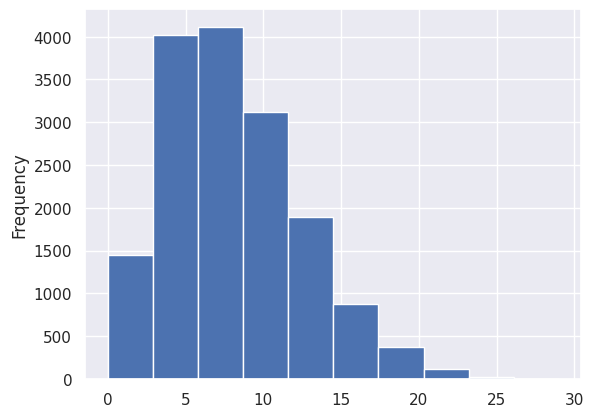

In [ ]:
# membuat visualisasi frekuensi stopwords
sns.set(font_scale=1)
temp['Stopwords'].plot(kind='hist')

### Membuat fungsi cleaning data

In [ ]:
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()

  text = text.split()
  text = [lemmatizer.lemmatize(word) for word in text]

  return ' '.join(text)

def remove_stopwords(text):

  text = [i for i in str(text).split() if i not in stop_words]

  return ' '.join(text)

def remove_number(text):
  text = ''.join([i for i in text if not i.isdigit()])

  return text

def lower_case(text):
  text = text.split()

  text = [word.lower() for word in text]

  return ' '.join(text)

def remove_punctuation(text):
  text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
  text = text.replace('؛',"", )

  ## remove extra whitespace
  text = re.sub('\s+', ' ', text)
  text =  " ".join(text.split())

  return text.strip()

def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    return url_pattern.sub(r'', text)

def remove_small_sentence(text):
  for i in range(len(df)):
    if len(df.text.iloc[i].spit() < 3):
      df.text.iloc[i] = np.nan

def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stopwords(text))
    df.Text=df.Text.apply(lambda text : remove_number(text))
    df.Text=df.Text.apply(lambda text : remove_punctuation(text))
    df.Text=df.Text.apply(lambda text : remove_url(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stopwords(sentence)
    sentence= remove_number(sentence)
    sentence= remove_punctuation(sentence)
    sentence= remove_url(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [ ]:
# membuat sample atau hasil dari fungsi diatas
normalized_sentence('im feeling pretty anxious')

'im feeling pretty anxious'

In [ ]:
df = normalize_text(df)

In [ ]:
df.head(10)

,Text,Emotion
0,didnt feel humiliated,sadness
1,go feeling hopeless damned hopeful around some...,sadness
2,im grabbing minute post feel greedy wrong,anger
3,ever feeling nostalgic fireplace know still pr...,love
4,feeling grouchy,anger
5,ive feeling little burdened lately wasnt sure,sadness
6,ive taking milligram time recommended amount i...,surprise
7,feel confused life teenager jaded year old man,fear
8,petronas year feel petronas performed well mad...,joy
9,feel romantic,love


## **Preprocessing data**

In [ ]:
# Membagi data menjadi train dan validation
train_set, val_set= train_test_split(df, test_size=0.2, shuffle=False)

In [ ]:
train_set.shape, val_set.shape

((12775, 2), (3194, 2))

In [ ]:
# Mempisahkan text dengan label
x_train = train_set['Text']
y_train = train_set['Emotion']

x_val = val_set['Text']
y_val = val_set['Emotion']

In [ ]:
# Melakukan encoding pada label
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)

In [ ]:
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [ ]:
# Transform class menjadi binary class matrix
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [ ]:
print(y_train)

[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


### Tahap Tokenizing

In [ ]:
tokenizer = Tokenizer(oov_token='-')
tokenizer.fit_on_texts(pd.concat([x_train, x_val], axis=0))

In [ ]:
len(tokenizer.word_index)

13479

In [ ]:
tokenizer.word_index['towards']

222

In [ ]:
x_train

0                                    didnt feel humiliated
1        go feeling hopeless damned hopeful around some...
2                im grabbing minute post feel greedy wrong
3        ever feeling nostalgic fireplace know still pr...
4                                          feeling grouchy
                               ...                        
12770    excited new tradition loved one day feel rich ...
12771           dwell matter feel infuriated lowly thought
12772    feeling confused happening around looking plan...
12773                                     im feeling lucky
12774             began feel sympathetic khezef sure right
Name: Text, Length: 12775, dtype: object

In [ ]:
# tokenizer.texts_to_sequences(x_train)
tokenizer.texts_to_sequences(x_train[0].split())# Melakukan tokenisasi per-kalimat

[[51], [2], [565]]

In [ ]:
# Membuat Bag of Words
tokenizer.texts_to_matrix(x_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
tokenizer.texts_to_matrix(x_train[0].split()).shape

(3, 13480)

In [ ]:
# Proses sequence
train_sequences = tokenizer.texts_to_sequences(x_train)
val_sequences = tokenizer.texts_to_sequences(x_val)

### **Padding**
Karena Vektor yang kita dapatkan tidak semuanya berada pada panjang yang sama, maka diperlukan padding sequences

In [ ]:
val_set.shape

(3194, 2)

In [ ]:
maxlen = max([len(i) for i in val_set['Text']])
maxlen

219

In [ ]:
x_train = pad_sequences(train_sequences, maxlen=219, truncating='pre')
x_val = pad_sequences(val_sequences, maxlen=219, truncating='pre')

In [ ]:
# Membuat vocabulary
vocabSize = len(tokenizer.index_word) + 1
print(f'Vocab size: {vocabSize}')

Vocab size: 13480


In [ ]:
train_sequences[0]

[51, 2, 565]

In [ ]:
x_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## **Embedding**
Dalam proses embedding ini, dilakukan beberapa metode yaitu, GloVe embedding, dan word vector

**Referensi** :


*   https://paperswithcode.com/method/glove
*   https://dzone.com/articles/introduction-to-word-vectors
* https://www.kaggle.com/code/sepidafs/text-classification-with-glove-lstm-gru-99-acc/notebook



In [ ]:
# GloVe embedding
glove_file_path = '/content/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
miss = 0
embedding_index = {}

In [ ]:
# Word Vectors
with open(glove_file_path) as f:
  for line in f:
    word, coef = line.split(maxsplit=1)
    coef = np.fromstring(coef, 'f', sep=' ')
    embedding_index[word] = coef
  print("Found %s word vectors" % len(embedding_index))

# Memasukkan word vector ke dalam vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
    hits += 1
  else:
    miss += 1
print("Converted %d word (%d miss)" % (hits, miss))

Found 400000 word vectors
Converted 12510 word (969 miss)


### **Modeling**

In [ ]:
model = Sequential([
    Embedding(vocabSize, 200, input_length=x_train.shape[1], weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0, return_sequences=True)),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0, return_sequences=True)),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0)),
    Dense(6, activation='softmax')
])

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.005),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 219, 200)          2696000   
                                                                 
 bidirectional (Bidirection  (None, 219, 512)          935936    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 219, 256)          656384    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 1542      
                                                        

In [ ]:
# Membuat callback
callback = EarlyStopping(monitor = 'val_loss', patience=4, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    batch_size = 256,
                    epochs = 30,
                    callbacks = [callback]
                    )

Epoch 1/30
50/50 [==============================] - 31s 370ms/step - loss: 1.3425 - accuracy: 0.4884 - val_loss: 0.8927 - val_accuracy: 0.6882
Epoch 2/30
50/50 [==============================] - 14s 290ms/step - loss: 0.6252 - accuracy: 0.7771 - val_loss: 0.3709 - val_accuracy: 0.8707
Epoch 3/30
50/50 [==============================] - 14s 290ms/step - loss: 0.3212 - accuracy: 0.8810 - val_loss: 0.2542 - val_accuracy: 0.9017
Epoch 4/30
50/50 [==============================] - 15s 298ms/step - loss: 0.2012 - accuracy: 0.9159 - val_loss: 0.1993 - val_accuracy: 0.9167
Epoch 5/30
50/50 [==============================] - 15s 302ms/step - loss: 0.1459 - accuracy: 0.9321 - val_loss: 0.1708 - val_accuracy: 0.9233
Epoch 6/30
50/50 [==============================] - 15s 308ms/step - loss: 0.1222 - accuracy: 0.9428 - val_loss: 0.1535 - val_accuracy: 0.9308
Epoch 7/30
50/50 [==============================] - 15s 309ms/step - loss: 0.0987 - accuracy: 0.9524 - val_loss: 0.1900 - val_accuracy: 0.9274

## **Visualisasi Plot loss dan training**

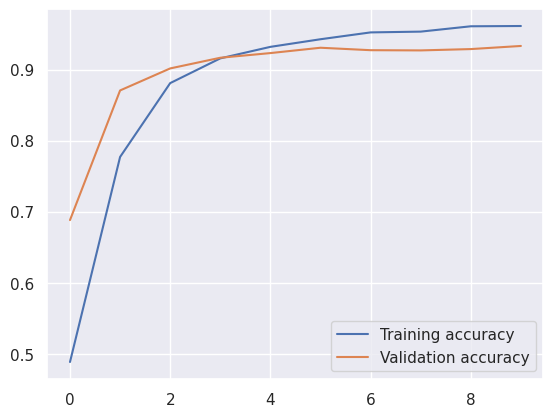

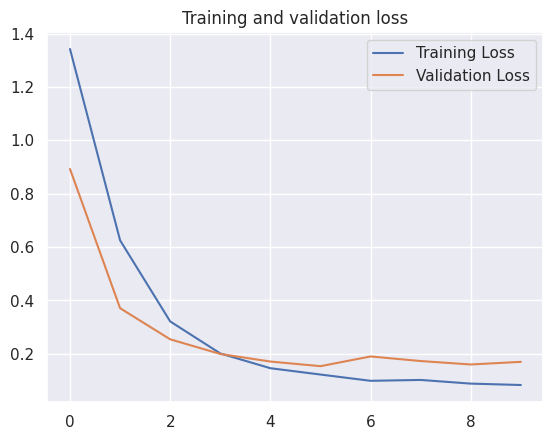

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(len(accuracy)), accuracy, label='Training accuracy')
plt.plot(range(len(accuracy)), val_acc, label='Validation accuracy')
plt.legend()
plt.figure()

plt.plot(range(len(accuracy)), loss, label='Training Loss')
plt.plot(range(len(accuracy)), val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## **Evaluasi Model**

In [ ]:
model.evaluate(x_val, y_val, verbose=1)

100/100 [==============================] - 3s 28ms/step - loss: 0.1535 - accuracy: 0.9308


[0.15353578329086304, 0.9308077692985535]

In [ ]:
sentence = input('')
print(sentence)
sentence = normalized_sentence(sentence)
sentence = tokenizer.texts_to_sequences([sentence])
sentence = pad_sequences(sentence, maxlen=219, truncating='pre')
result = label_encoder.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
proba =  np.max(model.predict(sentence))
print(f"{result} : {proba}\n\n")

my cat die
my cat die
1/1 [==============================] - 0s 34ms/step
fear : 0.5099772810935974


